In [2]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
import matplotlib.pyplot as plt
from scipy import signal
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale, Lambda
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from scipy.signal import get_window


from losses import *
from test_utils import *

In [3]:
def tone_burst(dt, centre_freq, n_cycles, n_samples, envelope='gaussian', offset=0, phase=lambda x:0):
    tone_length = n_cycles/centre_freq
    time_array, step = np.linspace(0, tone_length, int(tone_length/dt+1), retstep=True, endpoint=False)
    tone_burst = np.sin(2*np.pi*centre_freq*time_array+2*np.pi*centre_freq*phase(time_array))
    n_tone = tone_burst.shape[0]
    if envelope=='gaussian':
        limit = 3
        window_x = np.linspace(-limit, limit, n_tone)
        window = np.exp(-window_x**2/2)
    elif envelope=='rectangular':
        window = np.ones((tone_burst.shape[0],))
    else:
        raise Exception('Envelope type not implemented')
    tone_burst = np.multiply(tone_burst, window)
    window = get_window(('tukey', 0.05), n_tone, False)
    tone_burst = np.multiply(tone_burst, window)
    signal = np.pad(tone_burst, ((offset, n_samples-offset-n_tone),), mode='constant', constant_values=0)
    return signal

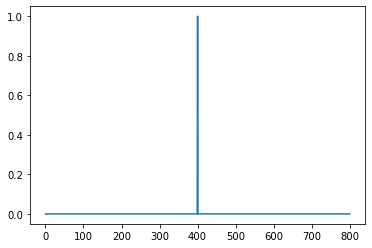

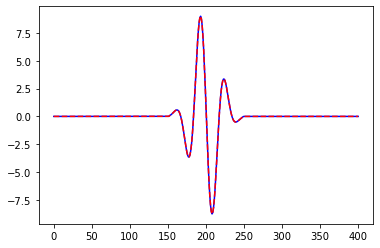

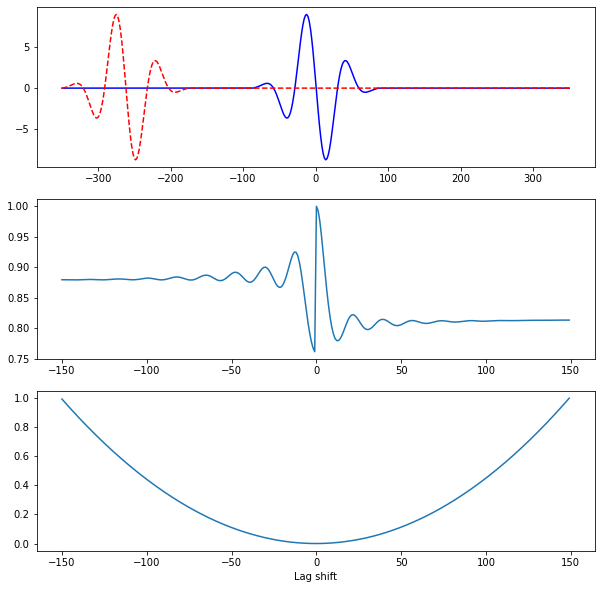

In [33]:
awlosses = []
l2losses = []
offsets = []

awloss       = AWLoss(epsilon=3e-4, store_filters="norm", method="fft", filter_dim=1, reduction="mean", std=1e-1)
mseloss      = nn.MSELoss(reduction="mean")

input = torch.tensor(10*tone_burst(1e-7, 3e5, 3, 401, offset=150), dtype=torch.float32).unsqueeze(0)
target = torch.tensor(10*tone_burst(1e-7, 3e5, 3, 401, offset=0), dtype=torch.float32).unsqueeze(0)
lags = torch.linspace(-350, 350, 401)
amps = torch.cat((torch.linspace(-1000, 1, 151)[:-1], torch.linspace(1, 1003, 150)))

awid = AWLoss(epsilon=0., store_filters="norm", method="fft", filter_dim=1, reduction="mean", std=1e-7)
_ = awid(input, input)
vid, _ = awid.filters[0], awid.T
vid = vid / torch.max(torch.abs(vid))
plt.plot(vid)
plt.show()

# print(len(amps), amps[150])
# plt.plot(amps)
# plt.show()

for i in range(0, 300, 1):
    t =  torch.tensor(10*tone_burst(1e-7, 3e5, 3, 401, offset=i), dtype=torch.float32).unsqueeze(0) * amps[i] 

    tg = t  #torch.abs(t)  #/ torch.max(torch.abs(t))
    inp = input # torch.abs(input) #/ torch.max(torch.abs(input))

    aw = awloss(inp, tg)
    v, T = awloss.filters[0], awloss.T

    # v = v / torch.sqrt(torch.sum(v**2))
    # T = -T + T.max()
    # l = T * v
    # l = 0.5 * l / torch.sqrt(torch.sum(v**2))
    # aw = torch.mean(l)
    
    l = vid - v
    l = 0.5 * l / torch.sqrt(torch.sum(l**2))
    aw = torch.mean(l)
    
    l2losses.append(mseloss(input, t).item())
    awlosses.append(aw.item())
    offsets.append(i - 150)

    if i == 150:
        plt.plot(input[0], "b")
        plt.plot(t[0], "r--")
        plt.show()

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(lags, input[0], "b")
axs[0].plot(lags, target[0], "r--")
axs[1].plot(offsets, awlosses / np.max(np.abs(np.asarray(awlosses))))
axs[2].plot(offsets, l2losses/ np.max(np.abs(np.asarray(l2losses))))
axs[2].set_xlabel("Lag shift")
plt.show()

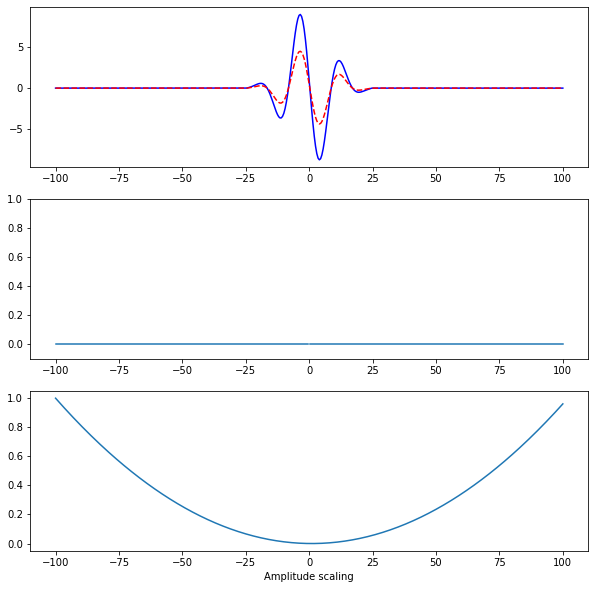

In [4]:
awlosses = []
l2losses = []
offsets = []

awloss       = AWLoss(epsilon=0., store_filters="norm", method="fft", filter_dim=1, reduction="mean", std=1e-5)
mseloss      = nn.MSELoss(reduction="mean")

signal = torch.tensor(10*tone_burst(1e-7, 3e5, 3, 401, offset=150), dtype=torch.float32).unsqueeze(0)
amps = torch.linspace(-100, 100, 401)

for a in amps:
    aw = awloss(signal, a * signal)
    v, T = awloss.filters[0], awloss.T
    v = v / torch.sqrt(torch.sum(v**2))
    T = -T + T.max()
    l = T * v
    l = l / torch.sqrt(torch.sum(v**2))
    l = torch.mean(l)
    
    l2losses.append(mseloss(signal, a*signal).item())
    awlosses.append(l.item())

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(amps, signal[0], "b")
axs[0].plot(amps, signal[0]*0.5, "r--")
axs[1].plot(amps, awlosses)# / np.max(np.abs(np.asarray(awlosses))))
axs[1].set_ylim(-0.1, 1)
axs[2].plot(amps, l2losses/ np.max(np.abs(np.asarray(l2losses))))
axs[2].set_xlabel("Amplitude scaling")
plt.show()


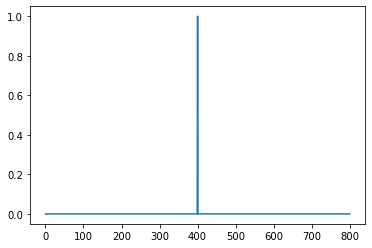

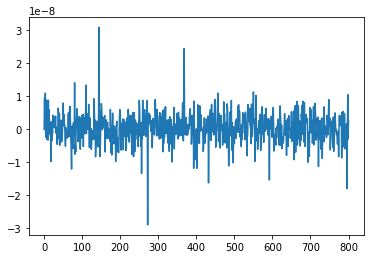

tensor(1.2931e-07, grad_fn=<SqrtBackward0>)
tensor(6.4654e-08, grad_fn=<DivBackward0>)


In [6]:
awloss       = AWLoss(epsilon=0., store_filters="norm", method="fft", filter_dim=1, reduction="mean", std=3e-7)
aw = awloss(input, input)
v, T = awloss.filters[0], awloss.T
plt.plot(v)
plt.show()
v = v / torch.sqrt(torch.sum(v**2))
l = T - v
plt.plot(l.detach())
plt.show()
l = torch.sqrt(torch.sum(l**2))
print(l)
print(aw)